## Task Details
This dataset is designed to understand the factors that lead to a person to work for a different company(leaving current job), by model(s) that uses the current credentials/demographics/experience to predict the probability of a candidate to look for a new job or will work for the company.

The whole data divided to train and test. Sample submission has been provided correspond to enrollee id of test set (enrolle id | target)

## Notes
The dataset is imbalanced.

Most features are categorical (Nominal, Ordinal, Binary), some with high cardinality.

Missing imputation can be a part of your pipeline as well.

## Features
enrollee_id : Unique ID for candidate

city: City code

city_development_index : Developement index of the city (scaled)

gender: Gender of candidate

relevent_experience: Relevant experience of candidate

enrolled_university: Type of University course enrolled if any

education_level: Education level of candidate

major_discipline :Education major discipline of candidate

experience: Candidate total experience in years

company_size: No of employees in current employer's company

company_type : Type of current employer

lastnewjob: Difference in years between previous job and current job

training_hours: training hours completed

target: 0 – Not looking for job change, 1 – Looking for a job change

## Importing Libraries

In [2]:
#%% Imports
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import lightgbm as lgb
import shap
%matplotlib inline

from pprint import pprint
from IPython.display import display 
from sklearn import model_selection
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, roc_auc_score

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/hr-analytics-job-change-of-data-scientists/sample_submission.csv
/kaggle/input/hr-analytics-job-change-of-data-scientists/aug_test.csv
/kaggle/input/hr-analytics-job-change-of-data-scientists/aug_train.csv


## Read in Training Data (aug_train.csv)

In [3]:
# Read aug_train.csv
aug_train = pd.read_csv('../input/hr-analytics-job-change-of-data-scientists/aug_train.csv')
# Initial Glance at Data
display(aug_train.info(verbose = True,null_counts=True))
print(aug_train.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  object 
 2   city_development_index  19158 non-null  float64
 3   gender                  14650 non-null  object 
 4   relevent_experience     19158 non-null  object 
 5   enrolled_university     18772 non-null  object 
 6   education_level         18698 non-null  object 
 7   major_discipline        16345 non-null  object 
 8   experience              19093 non-null  object 
 9   company_size            13220 non-null  object 
 10  company_type            13018 non-null  object 
 11  last_new_job            18735 non-null  object 
 12  training_hours          19158 non-null  int64  
 13  target                  19158 non-null  float64
dtypes: float64(2), int64(2), object(10)
me

null_counts is deprecated. Use show_counts instead


None

(19158, 14)


aug_train has 19,158 observations with 13 features and 1 target variable. The dataset has missing data and must be handled properly.

## EDA

In [4]:
# enrolle_id is an meaningless feature that is a unique value for each employee.
# count total number of unique values in enrollee_id column
print('Number of Unique Values: ' + str(aug_train['enrollee_id'].nunique()))

Number of Unique Values: 19158


In [5]:
# city has 123 unique values and is a categorical variable.
print('Number of Unique Values: ' + str(aug_train['city'].nunique()))
print('Number of NaN Values: ' + str(sum(aug_train['city'].isnull())))
# top 10 cities 
print((aug_train['city'].value_counts()[0:10]))

Number of Unique Values: 123
Number of NaN Values: 0
city_103    4355
city_21     2702
city_16     1533
city_114    1336
city_160     845
city_136     586
city_67      431
city_75      305
city_102     304
city_104     301
Name: city, dtype: int64


Number of Missing Values:  0


count    19158.000000
mean         0.828848
std          0.123362
min          0.448000
25%          0.740000
50%          0.903000
75%          0.920000
max          0.949000
Name: city_development_index, dtype: float64

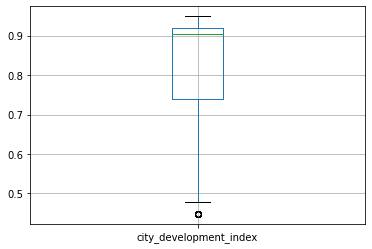

In [6]:
# city_development_index is Continous Variable

print("Number of Missing Values: ", aug_train['city_development_index'].isna().sum())
display(aug_train['city_development_index'].describe())
boxplot = aug_train.boxplot(column ='city_development_index')

In [11]:
# gender is Catagorical Variable: Male, Female, Other, or NaN
print("Number of Missing Values: ", aug_train['gender'].isna().sum())
fig = px.pie(aug_train['gender'].value_counts(), values='gender', names = aug_train['gender'].value_counts().index,title = 'gender',template='plotly_dark')
fig.show()

Number of Missing Values:  4508


In [12]:
# relevent_experience is Binary Variable with no missing values.
print("Number of Missing Values: ", aug_train['relevent_experience'].isna().sum())
fig = px.pie(aug_train['relevent_experience'].value_counts(), values='relevent_experience', 
             names = aug_train['relevent_experience'].value_counts().index,title = 'relevent_experience',template = 'plotly_dark')
fig.show()

Number of Missing Values:  0


In [10]:
# education_level is Catagorical Variable indicating education level of worker, has 460 missing values

print("Number of Missing Values: ", aug_train['education_level'].isna().sum())
fig = px.pie(aug_train['education_level'].value_counts(), values='education_level', 
             names = aug_train['education_level'].value_counts().index,title = 'education_level',template='plotly_dark')
fig.show()

Number of Missing Values:  460
